이번 예제에서는 사용자로부터 요구 사항을 수집한 후, 

이를 바탕으로 프롬프트를 생성하는 챗봇을 만드는 과정을 설명합니다. 

챗봇은 먼저 사용자로부터 요구 사항을 수집한 다음, 프롬프트를 생성하고 필요 시 사용자 피드백에 따라 이를 수정합니다. 

이러한 과정은 두 개의 상태로 나뉘며, LLM이 상태 전환 시점을 결정합니다.



In [ ]:
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core duckduckgo-search langchain-community chromadb

먼저, 사용자 요구 사항을 수집하는 그래프의 부분을 정의하겠습니다. 
이는 특정 시스템 메시지를 사용하는 LLM 호출로 이루어질 것입니다. 
LLM은 프롬프트를 생성할 준비가 되었을 때 호출할 수 있는 도구에 접근할 수 있습니다.

In [1]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel

In [2]:
template = """당신의 역할은 사용자가 어떤 유형의 프롬프트 템플릿을 만들고 싶은지에 대한 정보를 수집하는 것입니다.

다음의 정보를 사용자로부터 받아야 합니다:

- 프롬프트의 목적이 무엇인지
- 프롬프트 템플릿에 어떤 변수가 입력될 것인지
- 출력 결과에서 절대 해서는 안 되는 일에 대한 제약 사항
- 출력 결과에서 반드시 따라야 하는 요구사항

이 정보들을 명확하게 알 수 없다면, 사용자에게 구체적으로 질문하여 확인하세요! 추측으로 답변하거나 프롬프트를 작성하려고 하지 마세요.

모든 정보를 정확히 파악한 뒤에, 관련 도구를 호출하세요."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

## Generate Prompt
이제 프롬프트를 생성할 상태를 설정합니다. 

이를 위해 별도의 시스템 메시지와 도구 호출 이전의 모든 메시지를 필터링하는 함수가 필요합니다 
(이전 상태에서 프롬프트 생성을 결정한 시점이 도구 호출 시점이기 때문입니다).

In [3]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """다음 요구사항을 바탕으로 좋은 프롬프트 템플릿을 작성해줘:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

## Define the state logic
다음은 챗봇의 상태를 결정하는 로직입니다. 

마지막 메시지가 도구 호출이면, "프롬프트 생성기" (prompt)가 응답해야 하는 상태에 있습니다. 

마지막 메시지가 HumanMessage가 아니라면, 사용자가 다음으로 응답해야 한다는 것을 의미하므로 END 상태에 있습니다. 

마지막 메시지가 HumanMessage일 경우, 이전에 도구 호출이 있었다면 

prompt 상태에 있으며, 그렇지 않다면 "정보 수집" (info) 상태에 있습니다.

In [4]:
from typing import Literal

from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

이제 그래프를 생성할 수 있습니다. 

SqliteSaver를 사용하여 대화 기록을 영구적으로 저장할 것입니다.


In [6]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

graph = workflow.compile(checkpointer=memory)

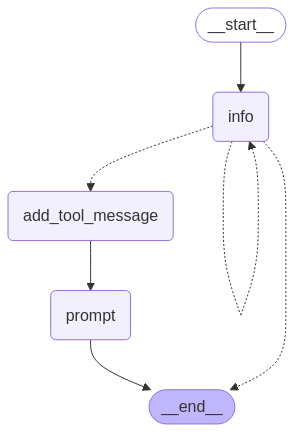

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import uuid

cached_human_responses = ["hi!"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")